In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import multiprocessing as mul
from scipy import stats
import pickle
from scipy.integrate import quad
from corner import corner
import pandas as pd
from scipy.stats import gaussian_kde
import dynesty as dyn

/tmp/ipykernel_126355/3051021382.py:36: RuntimeWarning: overflow encountered in scalar power
  return zeta * (eob**alpha1) * ((0.5 * ((1 + eob)**(1/mu))) ** ((alpha2 - alpha1) * mu))
/tmp/ipykernel_126355/3051021382.py:36: RuntimeWarning: overflow encountered in scalar power
  return zeta * (eob**alpha1) * ((0.5 * ((1 + eob)**(1/mu))) ** ((alpha2 - alpha1) * mu))


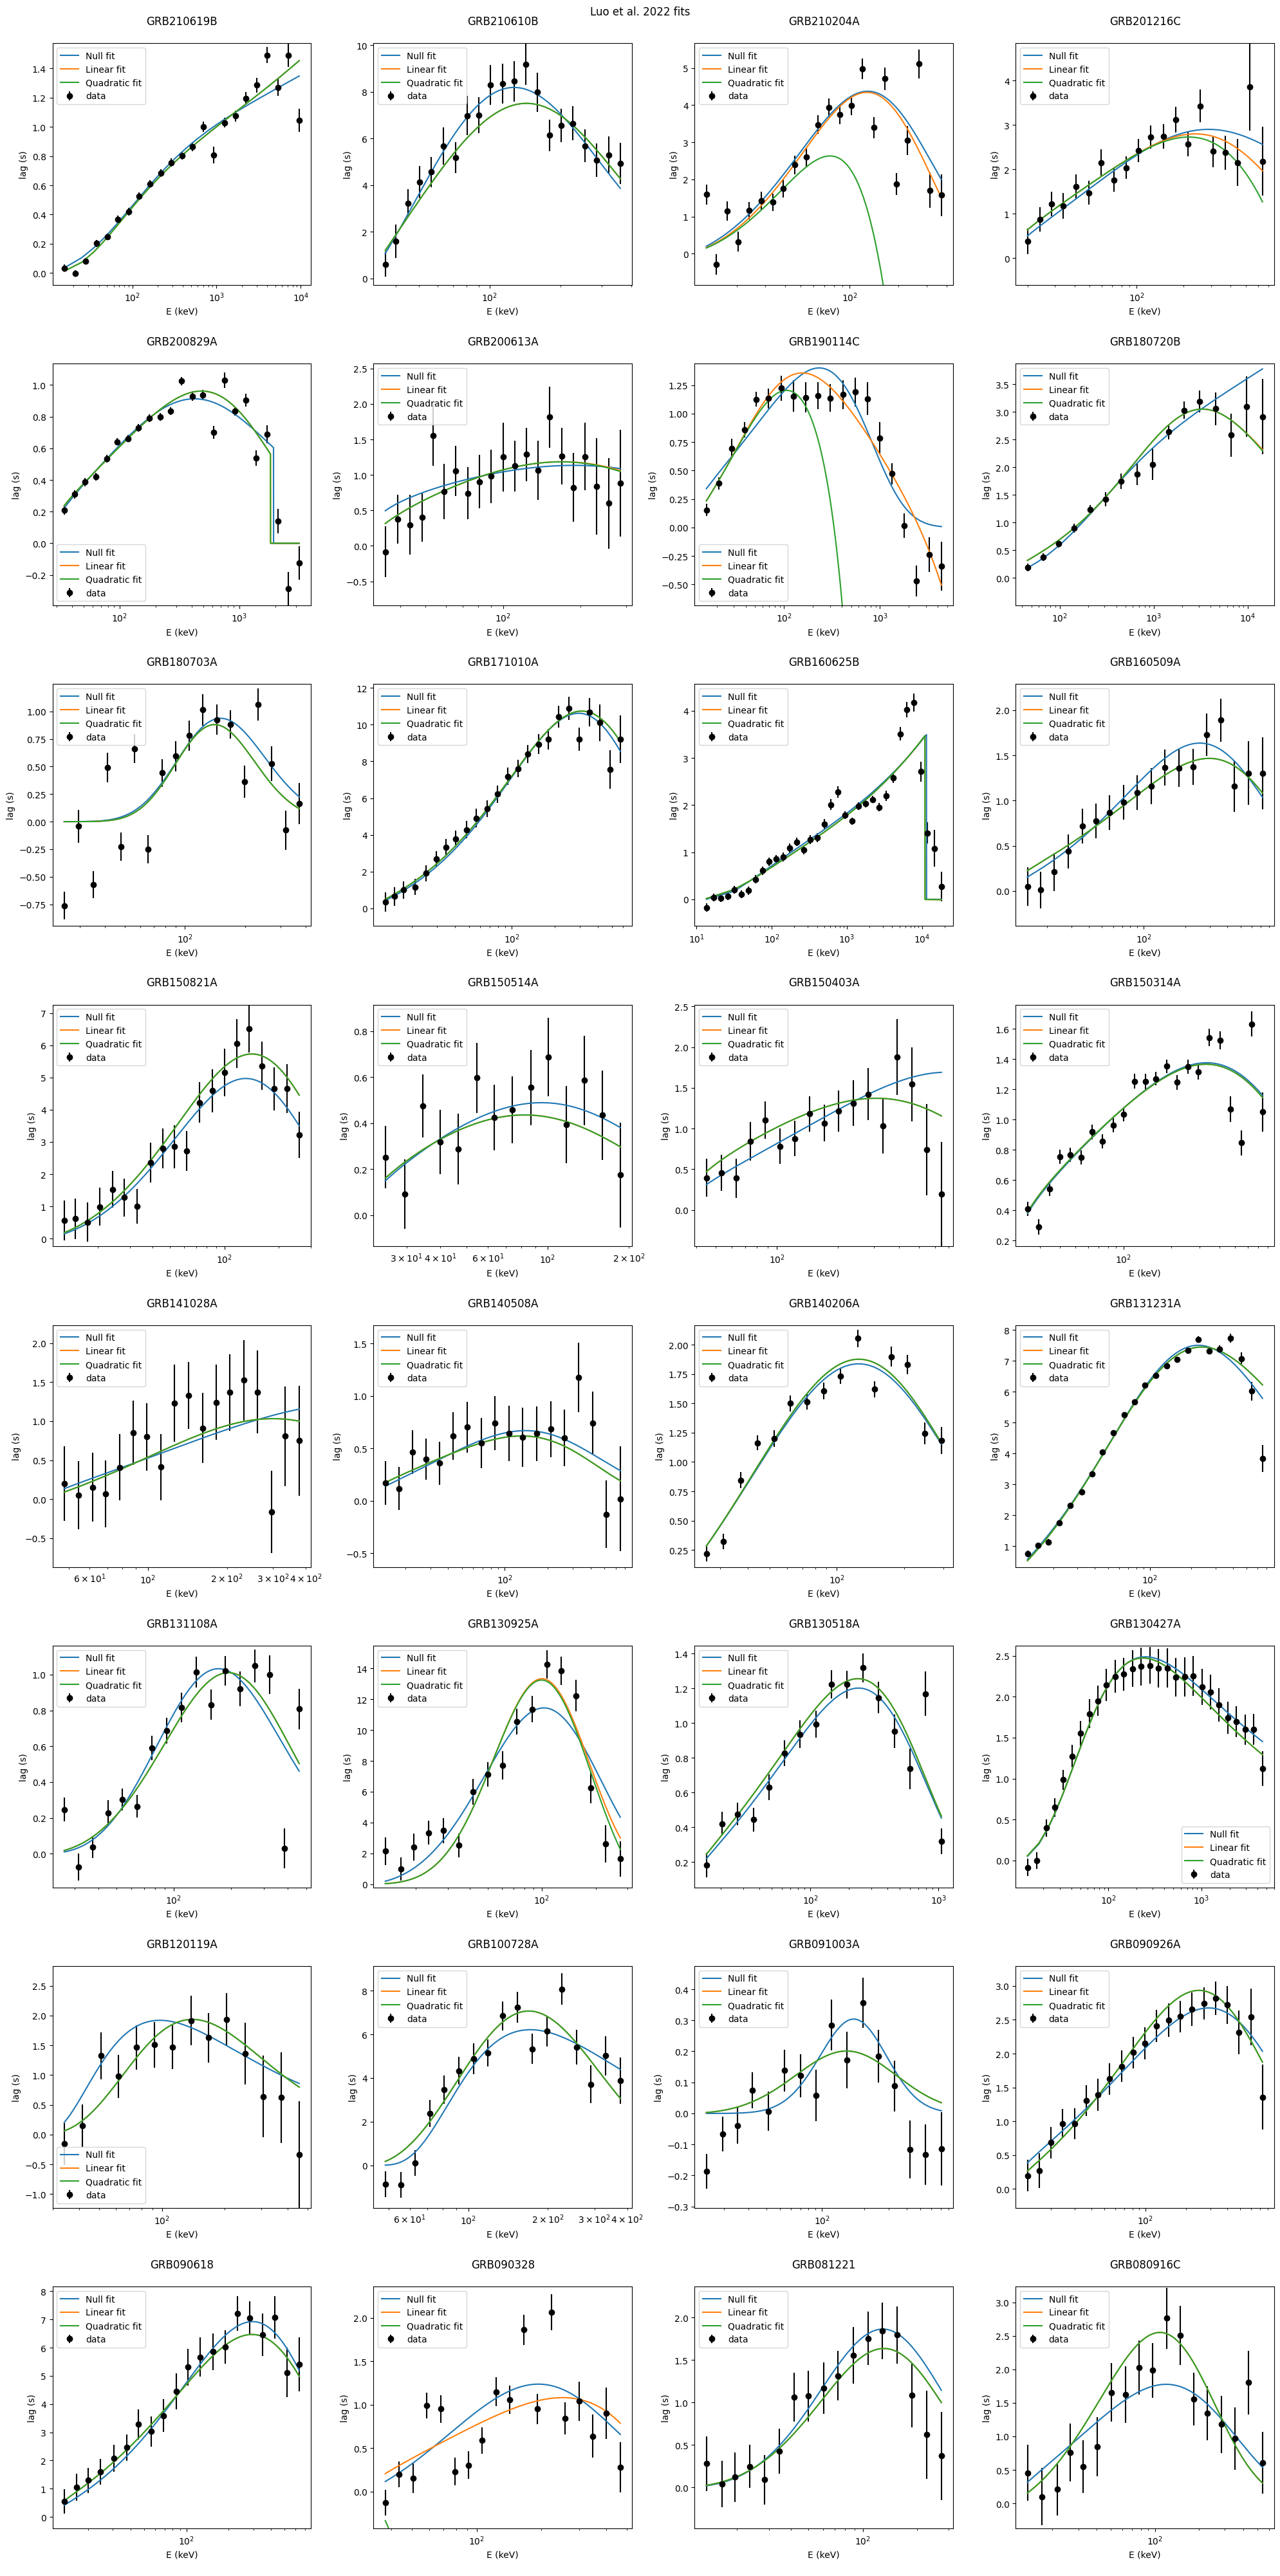

In [2]:
fig, ax = plt.subplots(8, 4, figsize=(20, 40))
GRBs = ['GRB210619B', 'GRB210610B', 'GRB210204A', 'GRB201216C', 'GRB200829A', 'GRB200613A', 'GRB190114C', 'GRB180720B', 'GRB180703A', 'GRB171010A', 'GRB160625B', 'GRB160509A', 'GRB150821A', 'GRB150514A', 'GRB150403A', 'GRB150314A', 'GRB141028A', 'GRB140508A', 'GRB140206A', 'GRB131231A', 'GRB131108A', 'GRB130925A', 'GRB130518A', 'GRB130427A', 'GRB120119A', 'GRB100728A', 'GRB091003A', 'GRB090926A', 'GRB090618', 'GRB090328', 'GRB081221', 'GRB080916C']
err_grb = GRBs
grbparam = pd.read_csv(os.getcwd() + '/../data/GRBPARAM.csv', index_col=0)
for grb in GRBs:
    grbname = grb + '.txt'
    grbname_wtht_ext = grbname.replace('.txt','')


    arr = np.loadtxt(os.getcwd() + '/asciidataof_fig1/32lag/'+grbname)
    data = [arr[:,0], arr[:,1], arr[:,2]]
    x = arr[:,0]
    y = arr[:,1]
    yerr = arr[:,2]

    #Properties of GRB
    E0 = grbparam[grbname.replace('.txt','')].E0
    E0rest = E0
    Erest = arr[:,0]    #in keV
    z_com = grbparam[grbname.replace('.txt','')].redshift #redshift
    H0=67.36 #Hubble constant km -1 Mpc s -1
    omega_m = 0.315
    omega_l = 1 - omega_m





    #MODELS

    #NULL model
    def nullhp(E, Eb, alpha1, alpha2, mu, zeta):
        
        eob = (E - E0) / (Eb)
        
        return zeta * (eob**alpha1) * ((0.5 * ((1 + eob)**(1/mu))) ** ((alpha2 - alpha1) * mu))


    def int_z(z_prime, n):
        integ_fn = lambda z: (1+z)**n / np.sqrt(omega_m * (1+z)**3 + omega_l)
        return quad( integ_fn, a=0, b=z_prime)[0]

    int_z1 = np.asarray(int_z(z_com, 1))
    int_z2 = np.asarray(int_z(z_com, 2))

    #LINEAR model
    def linearhp(E, logEqg, Eb, alpha1, alpha2, mu, zeta):
        
        e0qg = (E - E0) / (10 ** logEqg)
        
        return - (e0qg * int_z1)/H0 + nullhp(E, Eb, alpha1, alpha2, mu, zeta)

    #QUADRATIC model
    def quadhp(E, logEqg, Eb, alpha1, alpha2, mu, zeta):
        e0qg = (E**2 - E0 **2) / ((10 ** logEqg)**2)
        
        return -1.5 * (e0qg * int_z2)/H0 + nullhp(E, Eb, alpha1, alpha2, mu, zeta)


    #LOG-LIKELIHOODS
    def loglike_null(theta):
        Eb, alpha1, alpha2, mu, zeta = theta
        
        if alpha1 >= alpha2:
            model = nullhp(x,  Eb, alpha1, alpha2, mu, zeta)
            
            return sum(stats.norm.logpdf(*args) for args in zip(y,model,yerr))
        
        return -np.inf

    def loglike_linear(theta):
        logEqg, Eb, alpha1, alpha2, mu, zeta = theta
        
        if alpha1 >= alpha2:
            model = linearhp(x, logEqg, Eb, alpha1, alpha2, mu, zeta)
            
            return sum(stats.norm.logpdf(*args) for args in zip(y,model,yerr))
        
        return -np.inf

    def loglike_quad(theta):
        logEqg, Eb, alpha1, alpha2, mu, zeta = theta
        
        if alpha1 >= alpha2:
            model = quadhp(x, logEqg, Eb, alpha1, alpha2, mu, zeta)
            
            return sum(stats.norm.logpdf(*args) for args in zip(y,model,yerr))
        
        return -np.inf    


    #PRIORS
    Ebmax = 5000 #keV
    Ebmin = 0
    alpha1min = -3
    alpha1max = 10  
    alpha2min = -10
    alpha2max = 3
    mumin = 0
    mumax = 3
    zetamin = 0
    zetamax = 4
    eqglinmin = 1e-20
    eqglinmax = 1e20
    eqquadmin = 1e-20
    eqquadmax = 1e15
    logeq1min = 0
    logeq1max = 20
    logeq2min = 0
    logeq2max = 15


    #PRIOR DISTRIBUTIONS

    def prior_transform_null(theta):
        Eb, alpha1, alpha2, mu, zeta = theta
        return [Ebmax * Eb + Ebmin, (alpha1max - alpha1min) * alpha1 + alpha1min, (alpha2max - alpha2min) * alpha2 + alpha2min, (mumax - mumin) * mu + mumin, (zetamax - zetamin) * zeta + zetamin]

    def prior_transform_linear(theta):
        logEqg, Eb, alpha1, alpha2, mu, zeta = theta
        return [(logeq1max - logeq1min) * logEqg + logeq1min, Ebmax * Eb + Ebmin, (alpha1max - alpha1min) * alpha1 + alpha1min, (alpha2max - alpha2min) * alpha2 + alpha2min, mumax * mu + mumin, zetamax * zeta + zetamin]

    def prior_transform_quadratic(theta):
        logEqg, Eb, alpha1, alpha2, mu, zeta = theta
        return [(logeq2max - logeq2min) * logEqg + logeq2min, Ebmax * Eb + Ebmin, (alpha1max - alpha1min) * alpha1 + alpha1min, (alpha2max - alpha2min) * alpha2 + alpha2min, mumax * mu + mumin, zetamax * zeta + zetamin]


    threesamplers = ['_null_sampler.pkl', '_linear_sampler.pkl', '_quadratic_sampler.pkl']
    sampler0 = dyn.utils.restore_sampler('./outputs/sampler_saves/' + grb + threesamplers[0])
    sampler1 = dyn.utils.restore_sampler('./outputs/sampler_saves/' + grb + threesamplers[1])
    sampler2 = dyn.utils.restore_sampler('./outputs/sampler_saves/' + grb + threesamplers[2])
    results0 = sampler0.results
    results1 = sampler1.results
    results2 = sampler2.results


  


    #PLOTTING FITS

    nplot = 1000
    E = np.linspace(min(Erest), max(Erest), nplot)
    samples0 = dyn.utils.resample_equal( results0.samples, np.exp(results0.logwt - results0.logz[-1]))
    # samples0 = np.median(samples0, axis=0)
    samples0 = samples0[np.argmax(results0.logl)]

    samples1 = dyn.utils.resample_equal( results1.samples, np.exp(results1.logwt - results1.logz[-1]))
    # samples1 = np.median(samples1, axis=0)
    samples1 = samples1[np.argmax(results1.logl)]

    samples2 = dyn.utils.resample_equal( results2.samples, np.exp(results2.logwt - results2.logz[-1]))
    # samples2 = np.median(samples2, axis=0)
    samples2 = samples2[np.argmax(results2.logl)]
    null_fit = np.round([nullhp(E[i], samples0[0], samples0[1], samples0[2], samples0[3], samples0[4]) for i in range(nplot)], 10)
    liv_lin_fit = np.round([linearhp(E[i], samples1[0], samples1[1], samples1[2], samples1[3], samples1[4], samples1[5]) for i in range(nplot)], 10)
    liv_quad_fit = np.round([quadhp(E[i], samples1[0], samples1[1], samples1[2], samples1[3], samples1[4], samples1[5]) for i in range(nplot)], 10)



    
    
    ax[err_grb.index(grb)//4, err_grb.index(grb)%4].errorbar(Erest, y, yerr, fmt='o', color='black', label='data')
    ax[err_grb.index(grb)//4, err_grb.index(grb)%4].plot(E, null_fit, label='Null fit')
    ax[err_grb.index(grb)//4, err_grb.index(grb)%4].plot(E, liv_lin_fit,label='Linear fit')
    ax[err_grb.index(grb)//4, err_grb.index(grb)%4].plot(E, liv_quad_fit, label='Quadratic fit')
    ax[err_grb.index(grb)//4, err_grb.index(grb)%4].set_xscale('log')
    ax[err_grb.index(grb)//4, err_grb.index(grb)%4].set_ylim(min(y) - max(abs(yerr)), max(y) + max(abs(yerr)))
    ax[err_grb.index(grb)//4, err_grb.index(grb)%4].legend()
    ax[err_grb.index(grb)//4, err_grb.index(grb)%4].set_xlabel('E (keV)\n')
    ax[err_grb.index(grb)//4, err_grb.index(grb)%4].set_ylabel('lag (s)')
    ax[err_grb.index(grb)//4, err_grb.index(grb)%4].set_title(grb + '\n')
    
    

    

plt.tight_layout()
plt.suptitle('Luo et al. 2022 fits\n\n', y=1.0)
plt.savefig('./outputs/fits/ERR_fits.png', facecolor='white', format='png')
plt.show()

In [3]:
len(os.listdir('./outputs/fits/'))

33